## **EMOTION CLASSIFICATION WITH ELECTROENCEPHALOGRAPHY RECORDS**

In [1]:
import pandas as pd 

In [2]:
measurements = pd.read_csv('emotions.csv')
measurements.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


In the data set, the **emotions** of participants (1 male, 1 female) are categorized into three groups. The participant's **positive** and **negative** emotions were invoked with film clips. **Neutral** emotions, on the other hand, were invoked in an environment where no stimuli exist. The brainwave data were recorded during this period with the use of Muse, which is a kind of wearable brain sensing headband.

In [3]:
from collections import Counter

labels = measurements['label']
Counter(labels)

Counter({'NEGATIVE': 708, 'NEUTRAL': 716, 'POSITIVE': 708})

Even though the number of observations is higher in one class, this difference is very small. The data can be seen as **balanced**. I will use **accuracy** as the **performance metrics** throughout the project.

**Identification of Problematic Features**

Before starting, it is always good to **check** the data and handle any **missing**, **duplicated** or any **other problematic values**.

In [4]:
na_values = measurements.isnull().sum().sum()
print("The number of missing values in the data frame is {}.".format(na_values))

The number of missing values in the data frame is 0.


In [5]:
import numpy as np 

unique_values = measurements.nunique()
single_values = np.sum(unique_values==1)
print("The number of columns which contains single value is {}.".format(single_values))

The number of columns which contains single value is 0.


In [6]:
dupl = measurements.duplicated()
print("The number of duplicated rows in the data is {}.".format(dupl.sum()))

The number of duplicated rows in the data is 0.


In [7]:
print("There are {}".format(measurements.shape[0]), "training examples","and {}".format(measurements.shape[1]), 
      "variables in the data frame. One of these variables is the label of the data.")

There are 2132 training examples and 2549 variables in the data frame. One of these variables is the label of the data.


It looks like there are no missing values and no duplicated rows in the data set. Besides, no feature contains a single value. Therefore, we don't need to do anything about these situations in the data preprocessing step. 

**Random Forest**

In [10]:
from sklearn.preprocessing import StandardScaler

features = measurements.columns[0:2548]
X = measurements.loc[:,features].values
y = measurements['label'].values

X = StandardScaler().fit_transform(X)

In [11]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=21,stratify=y)

param_rf = {'n_estimators': [10,20,30,40,50],
            'max_features': ['sqrt'],
            'max_depth': [80,120,160,200],
            'min_samples_split': [3,5,7],
            'min_samples_leaf': [1,2],
            'bootstrap': [False]}

rf = RandomForestClassifier()
rf_cv = RandomizedSearchCV(rf, param_rf, cv=5,n_iter=50)
rf_cv.fit(X_train,y_train)
rf_cv.score(X_test,y_test)

0.9962476547842402

In [13]:
rf_cv.best_params_

{'n_estimators': 50,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 120,
 'bootstrap': False}

**PCA's and LDA's Effect on Accuracy**

**Principal Component Analysis** is one of the methods to **reduce** the number of **features**. The directions (principal components) that maximize the variance in the data set are tried to be found in this method. And the method ignores the labels of the data during this process. Therefore, it can be seen as **"Unsupervised Learning"**. The number of directions is selected based on how much those directions explain the information from the real data. 

**Linear Discriminant Analysis** is another method that is used to reduce the number of features in the data. In contrast with the Principal Component Analysis, it **computes** the **directions** (discriminants) **according to the labels** of the data set. Therefore, it can be seen as a **"Supervised Learning"** algorithm. It computes the directions to maximize the separation between multiple classes.

In [218]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
   
def pca_or_lda(method, output, pca_or_lda_parameters):
    if method== 'pca':
            pca = PCA(pca_or_lda_parameters)
            X_train_reduced = pca.fit_transform(X_train)
            X_test_reduced = pca.transform(X_test)
    elif method =='lda': 
            lda = LinearDiscriminantAnalysis(n_components=pca_or_lda_parameters)
            X_train_reduced = lda.fit_transform(X_train,y_train)
            X_test_reduced = lda.transform(X_test)          
    if output=='score':
        param_rf = {'n_estimators': [10,20,30,40,50],
                    'max_features': ['sqrt'],
                    'max_depth': [80,120,160,200],
                    'min_samples_split': [3,5,7],
                    'min_samples_leaf': [1,2],
                    'bootstrap': [False]}
        rf = RandomForestClassifier()
        rf_cv = RandomizedSearchCV(rf, param_rf, cv=5,n_iter=50)
        rf_cv.fit(X_train_reduced,y_train)
        rf_cv.score(X_test_reduced,y_test)    
        score = rf_cv.score(X_test_reduced,y_test)
        return score
    elif output=='reduction':
        return X_train_reduced,X_test_reduced         

In [219]:
pca_score = round(pca_or_lda(method = "pca", output= "score", pca_or_lda_parameters = 0.95),2)
lda_score = round(pca_or_lda(method = "lda", output= "score", pca_or_lda_parameters = 2),2)

print("When we use PCA in dimensionality reduction, and select the number of components that will cover 95% of the variance,",
      "the accuracy of the Random Forest model is {}.".format(pca_score), 
      "When we used LDA, however, and select the number of components as 2, the accuracy of the model in the test set is {}.".format(lda_score))

When we use PCA in dimensionality reduction, and select the number of components that will cover 95% of the variance, the accuracy of the Random Forest model is 0.95. When we used LDA, however, and select the number of components as 2, the accuracy of the model in the test set is 0.73.


As can be seen, PCA performs much better than LDA. Therefore, I will try to use PCA in the dimensionality reduction process. To choose the parameter of the PCA, on the other hand, I will make a **list of the ratio of explained variance** and **compare** the accuracy levels corresponding to these ratios. In the end, I will **choose the ratio** which gives me the **highest accuracy** in the test set. I will use the Random Forest model to evaluate the accuracies.

In [149]:
pca_param_list = np.arange(0.70,0.99,0.025)

accuracy_w_pca = []

for val in pca_param_list:
    accuracy = round(pca_or_lda(method="pca", output= "score", pca_or_lda_parameters = val),4)
    accuracy_w_pca.append(accuracy)

In [153]:
rf_score = round(rf_cv.score(X_test,y_test),4)
accuracy_wo_pca = np.repeat(rf_score,len(pca_param_list))

In [183]:
%config InlineBackend.figure_format = 'svg'

In [184]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [8, 8]

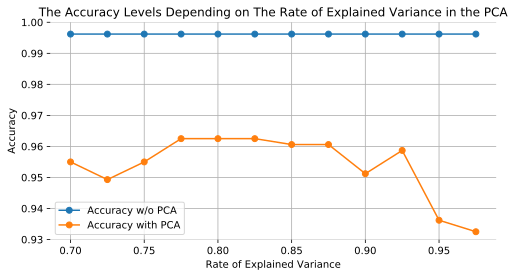

In [192]:
fig = plt.figure(figsize=[8,4])
ax = fig.add_subplot(1,1,1,frameon=False)
ax.plot(pca_param_list, accuracy_wo_pca, marker='o')
ax.plot(pca_param_list, accuracy_w_pca, marker='o')
ax.set_title("The Accuracy Levels Depending on The Rate of Explained Variance in the PCA")
ax.set_xlabel("Rate of Explained Variance")
ax.set_ylabel("Accuracy")
ax.set_ylim([0.93,1])
ax.grid()
ax.legend(["Accuracy w/o PCA","Accuracy with PCA"])
plt.show()


There is no need to apply PCA since it gives lower accuracies at all levels. I will continue my calculations with the original training and test sets.

**Detecting the Most Important Features**

Adding new features is one way to increase the accuracy of the model. Detecting the most important features, and **adding** different **combinations** of these **important features** to the data may **increase** the **accuracy** of the model.

ExtreTreesClassifier is one of the methods used to detect the important features in the data. Every time we call the classifier, sub-samples are **randomly** generated and therefore we observe **different results**. I will **call** the **classifier** **1000 times**, add up these 1000 results and detect the most important features. The reason why I wanted to calculate the importance of the features 1000 times is to **remove the randomness** as we do in **Central Limit Theorem**.

In [21]:
from sklearn.ensemble import ExtraTreesClassifier

feature_imp = []

for x in range(1,1000): 
    model = ExtraTreesClassifier()
    model.fit(X,y)
    feature_imp =+ model.feature_importances_

In [23]:
from operator import itemgetter
from heapq import nlargest, nsmallest

largest10 = nlargest(10, enumerate(feature_imp), itemgetter(1))

In [25]:
largest10_col_name = []
largest10_values = []
largest10_index = []

for index, value in largest10: 
    name = 'pc'+ str(index+1)
    largest10_col_name.append(name)
    largest10_values.append(value)
    largest10_index.append(index)

After calculating the importance of all the features, I will select the most important 10 features and their indices in the data.

In [27]:
largest10_df = pd.DataFrame({'column':largest10_col_name, 
                             'values':largest10_values})

largest10_df.sort_values('values',inplace=True)

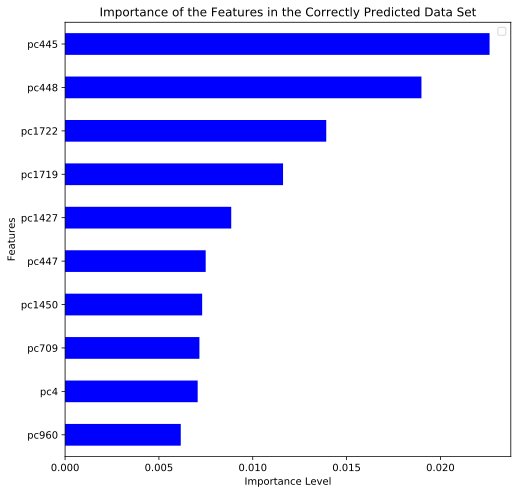

In [197]:
ax = largest10_df.plot(kind='barh',y='values',x='column',color='blue')
ax.set_xlabel("Importance Level")
ax.set_ylabel("Features")
ax.set_title("Importance of the Features in the Correctly Predicted Data Set")
ax.legend("")
plt.show()

The **10 most important features** are shown in the plot above. In the next step, I will **create polynomial combinations** of these features, add them to the data and try to increase the accuracy a little bit more. 

**Adding the Polynomial Variations of the Important Features**

In [33]:
def view_results (array, ind, row_or_column):
    if row_or_column=="row":
        df = pd.DataFrame(array[ind,:])
        col_names = []
        for val in range(1,df.shape[1]+1): 
            col = 'pc'+str(val)
            col_names.append(col)
        df.columns = col_names        
    elif row_or_column=="column":   
        df = pd.DataFrame(array[:,ind])
        column_name = []
        for val in range(0,df.shape[1]): 
            col = 'pc' + str(val+1)
            column_name.append(col)
        df.columns = column_name    
    return df    

In [ ]:
X_largest_10 = view_results(X, largest10_index, row_or_column="column") 

In [122]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=4,include_bias=False)
X_poly = poly.fit_transform(X_largest_10)

In [123]:
smallest990 = nsmallest(990, enumerate(feature_imp), itemgetter(1))

smallest990_index= []

for x in range(len(smallest990)): 
    smallest = smallest990[x][0]
    smallest990_index.append(smallest)
    
X_smallest_excluded = np.delete(X, smallest990_index,axis=1)    

In [133]:
X_poly_df = pd.DataFrame(X_poly[:,range(10,X_poly.shape[1])])
X_smallest_excluded_df = pd.DataFrame(X_smallest_excluded)

X_transformed = pd.concat([X_poly_df, X_smallest_excluded_df],axis=1)

In [135]:
X_transformed = StandardScaler().fit_transform(X_transformed)

X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(X_transformed, y, test_size=0.25,random_state=21,stratify=y)

rf_tr = RandomForestClassifier()
rf_tr_cv = RandomizedSearchCV(rf_tr, param_rf, cv=5,n_iter=50)
rf_tr_cv.fit(X_train_tr,y_train_tr)
rf_tr_cv.score(X_test_tr,y_test_tr)

0.9943714821763602

After getting the 10 most important features, and creating the polynomial combinations of these features, I obtained 1000 new features. 10 of these features were already in the original data. In other words, there are 990 new features after combining 10 features in different ways. Because there are already **many features** compared to the number of training examples, I didn't want to increase the number of features by adding those new features. Therefore, I **excluded** the **990 features which have the smallest importance** and **included** the **new** 990 **features** in place of these excluded features.

After training the Random Forest model on the new data set, the **accuracy** **decreased** around **0.2%** but, likely, this decrease **occurred randomly**.

In [141]:
X_poly = StandardScaler().fit_transform(X_poly)

X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.25,random_state=21,stratify=y)

rf_poly = RandomForestClassifier()
rf_poly_cv = RandomizedSearchCV(rf_poly, param_rf, cv=5,n_iter=50)
rf_poly_cv.fit(X_train_poly,y_train_poly)
rf_poly_cv.score(X_test_poly,y_test_poly)

0.9549718574108818

I also wanted to use the synthetic data I obtained after combining the most important features in my model. The accuracy decreased by around 4% when I used 1000 features I obtained with the combination of the most important 10 features.

**Confusion Matrix and Classification Report of the Best Model**

In [221]:
y_pred_test_rf = rf_cv.predict(X_test)
y_pred_train_rf = rf_cv.predict(X_train)
y_pred_prob_rf = rf_cv.predict_proba(X_test)[:,1]

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

cr_rf = classification_report(y_pred_test_rf, y_test)
print(cr_rf)

              precision    recall  f1-score   support

    NEGATIVE       1.00      0.99      1.00       178
     NEUTRAL       0.99      1.00      1.00       178
    POSITIVE       0.99      0.99      0.99       177

    accuracy                           1.00       533
   macro avg       1.00      1.00      1.00       533
weighted avg       1.00      1.00      1.00       533



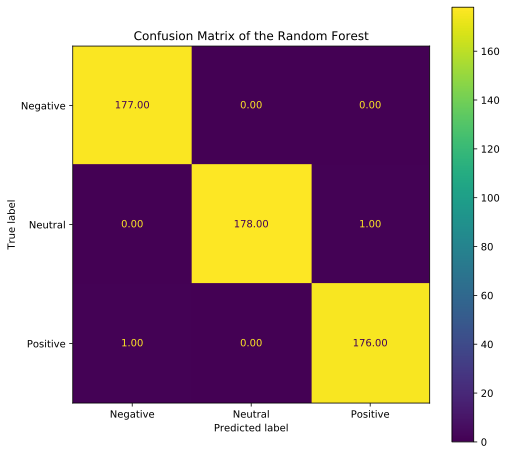

In [220]:
plot_confusion_matrix(rf_cv, X_test, y_test, 
                      display_labels = ['Negative','Neutral','Positive'],
                      values_format='.2f')
plt.title("Confusion Matrix of the Random Forest")
plt.show()

**Summary**

In summary, I **couldn't find** a **way** to **increase** the **accuracy from 99.62%** and selected the Random Forest model I created at the very beginning as the best model since it gives the highest accuracy. 

In the end, the model predicted all people who were feeling negative during the recording correctly. And it **predicted** **only the emotions of 2 people incorrectly** and that can be still considered as a potentially interesting result.